<a href="https://colab.research.google.com/github/Spokuri2003/btc-regime-detection/blob/main/BTC_Regime_Model_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Regime Classification for Bitcoin Using Unsupervised Learning
**Author:** Swathi Pokuri  
**Research Note**  
**Objective:** Identify statistically meaningful market regimes for Bitcoin and evaluate a regime-aware trading strategy.


## Executive Summary

Financial markets exhibit distinct behavioral regimes such as trending phases, stressed volatility events, and low-variance consolidations. Identifying and modeling these regimes is essential for systematic trading, risk management, and quantitative research.

This study constructs a Bitcoin regime detection framework using:
- Feature engineering (returns, realized volatility, trend)
- Standardization
- K-Means clustering
- Regime diagnostics (transition structure, centroids, silhouette score)
- A basic regime-aware long/short strategy

The notebook follows institutional quantitative research standards.


In [60]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

plt.style.use("seaborn-v0_8")


## Data Acquisition
Daily OHLCV data for Bitcoin (BTC-USD) is sourced from Yahoo Finance beginning in 2016.


In [62]:
# Download BTC
btc = yf.download("BTC-USD", start="2016-01-01")

# Flatten MultiIndex columns (yfinance creates multiindex by default)
btc.columns = [col[0] for col in btc.columns]

# Standardize column names
btc = btc.rename(columns=str.capitalize)

# Keep only essential fields
btc = btc[["Open","High","Low","Close","Volume"]]

btc.head()


/tmp/ipython-input-374398853.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2016-01-01")
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,34522600


## Feature Engineering

Three features are constructed:

- **Returns:** Daily log returns for short-horizon behavior.
- **Volatility:** 30-day realized volatility (rolling standard deviation).
- **Trend:** 30-day percent price change representing medium-term direction.

These features form the basis for regime segmentation.


In [63]:
btc["Returns"] = np.log(btc["Close"] / btc["Close"].shift(1))
btc["Volatility"] = btc["Returns"].rolling(window=30).std()
btc["Trend"] = btc["Close"].pct_change(30)

btc = btc.dropna()
btc.head()


,Open,High,Low,Close,Volume,Returns,Volatility,Trend
Date,,,,,,,,
2016-01-31,378.292999,380.346985,367.834991,368.766998,37894300,-0.025404,0.044373,-0.150960
2016-02-01,369.350006,378.071991,367.957001,373.056000,51656700,0.011564,0.044478,-0.139309
2016-02-02,372.920013,375.882996,372.920013,374.447998,40378700,0.003724,0.044503,-0.129213
2016-02-03,374.645996,374.950012,368.045013,369.949005,45933400,-0.012088,0.044466,-0.145794
2016-02-04,370.174011,391.608002,369.993011,389.593994,69285504,0.051740,0.045668,-0.098079


## Exploratory Feature Analysis

We analyze empirical feature distributions to confirm suitability for clustering.

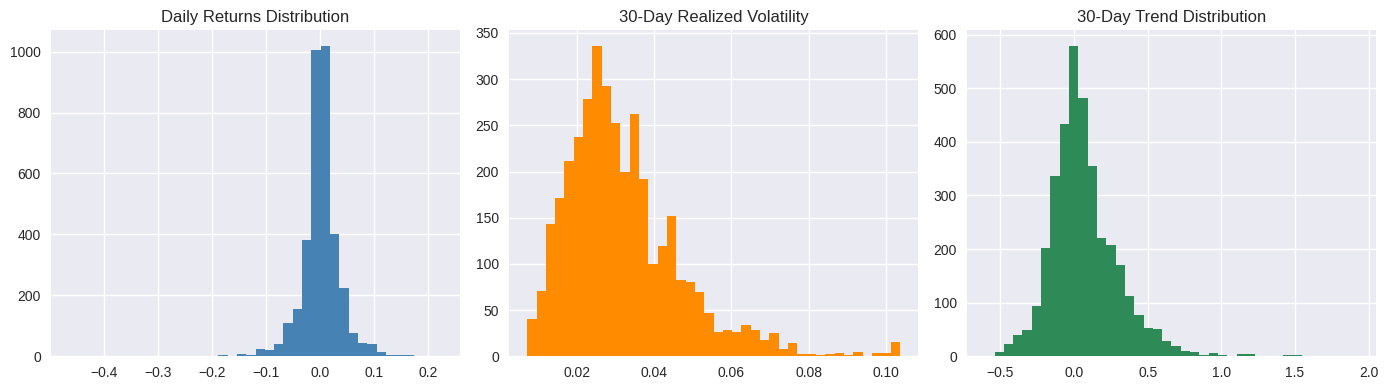

In [65]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
btc["Returns"].hist(bins=40, color="steelblue")
plt.title("Daily Returns Distribution")

plt.subplot(1,3,2)
btc["Volatility"].hist(bins=40, color="darkorange")
plt.title("30-Day Realized Volatility")

plt.subplot(1,3,3)
btc["Trend"].hist(bins=40, color="seagreen")
plt.title("30-Day Trend Distribution")

plt.tight_layout()
plt.show()


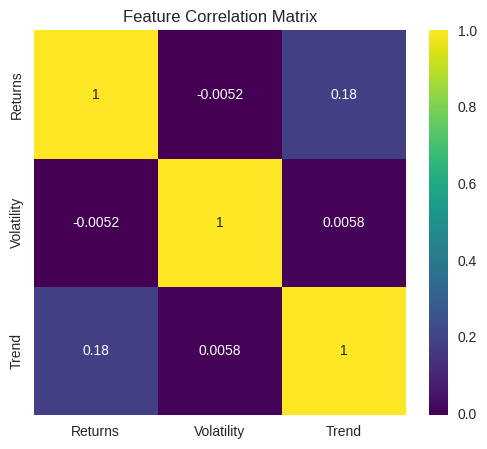

In [66]:
plt.figure(figsize=(6,5))
sns.heatmap(btc[["Returns","Volatility","Trend"]].corr(),
            annot=True, cmap="viridis")
plt.title("Feature Correlation Matrix")
plt.show()


## Regime Classification via K-Means

Features are standardized and clustered using K-Means with **K=3**, representing:
1. Bullish/trending regimes  
2. Neutral/low-volatility regimes  
3. High-volatility stressed regimes  


In [67]:
features = btc[["Returns","Volatility","Trend"]]

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
btc["Regime"] = kmeans.fit_predict(scaled)

btc[["Returns","Volatility","Trend","Regime"]].head()


,Returns,Volatility,Trend,Regime
Date,,,,
2016-01-31,-0.025404,0.044373,-0.150960,0
2016-02-01,0.011564,0.044478,-0.139309,0
2016-02-02,0.003724,0.044503,-0.129213,0
2016-02-03,-0.012088,0.044466,-0.145794,0
2016-02-04,0.051740,0.045668,-0.098079,0


## Regime Diagnostics

We evaluate:
- Transition probabilities
- Cluster centroid profiles
- Silhouette score
- Regime-specific feature means


In [69]:
trans = pd.crosstab(
    btc["Regime"].shift(1),
    btc["Regime"],
    normalize=0
)
trans


Regime,0,1,2
Regime,,,
0.0,0.729958,0.112518,0.157525
1.0,0.121986,0.743262,0.134752
2.0,0.048365,0.046522,0.905113


In [70]:
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=["Returns_z","Volatility_z","Trend_z"]
)
centroids


,Returns_z,Volatility_z,Trend_z
0,-0.587291,1.224807,-0.768775
1,0.608687,0.491548,1.393801
2,-0.004490,-0.560341,-0.199022


In [71]:
silhouette_score(scaled, btc["Regime"])


np.float64(0.33682232158635556)

In [72]:
btc.groupby("Regime")[["Returns","Volatility","Trend"]].mean()


,Returns,Volatility,Trend
Regime,,,
0,-0.019269,0.050400,-0.111407
1,0.023088,0.039371,0.400555
2,0.001320,0.023599,0.023333


### Regime Interpretation

Based on centroid values and feature means:
- **Regime 0:** Positive trend with moderate volatility — trending bullish regime  
- **Regime 1:** Low volatility with minimal trend — consolidation regime  
- **Regime 2:** Elevated volatility with negative returns — stressed or crash regime  


## Regime-Aware Strategy

A simple heuristic strategy is constructed:

- Long (1x) during bullish regimes  
- Flat (0x) during neutral regimes  
- Short (-1x) during stressed regimes  


In [73]:
btc["Position"] = btc["Regime"].map({0:1, 1:0, 2:-1})

btc["StrReturn"] = btc["Position"] * btc["Returns"]
btc["StrEq"] = (1 + btc["StrReturn"]).cumprod()

btc["BH"] = (1 + btc["Returns"]).cumprod()

btc[["StrEq","BH"]].tail()


,StrEq,BH
Date,,
2025-11-22,1.401047e-08,22.338052
2025-11-23,1.365799e-08,22.900046
2025-11-24,1.342932e-08,23.283447
2025-11-25,1.357135e-08,23.037190
2025-11-26,1.354241e-08,23.086318


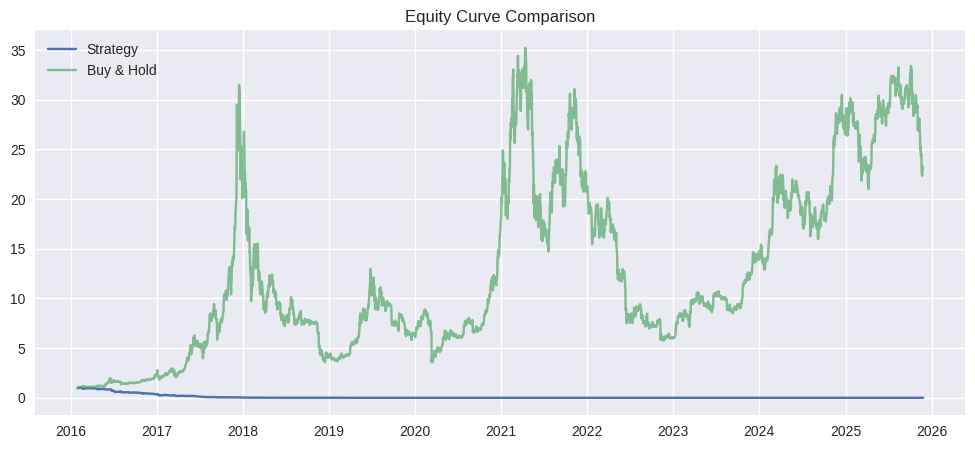

In [74]:
plt.figure(figsize=(12,5))
plt.plot(btc["StrEq"], label="Strategy")
plt.plot(btc["BH"], label="Buy & Hold", alpha=0.7)
plt.title("Equity Curve Comparison")
plt.legend()
plt.show()


## Performance Evaluation

We compute:
- Annualized return
- Annualized volatility
- Sharpe ratio
- Maximum drawdown
- Win rate


In [75]:
r = btc["StrReturn"]

ann_ret = (1 + r.mean())**252 - 1
ann_vol = r.std() * np.sqrt(252)
sharpe = ann_ret / ann_vol

rolling_max = btc["StrEq"].cummax()
dd = (btc["StrEq"] - rolling_max) / rolling_max
max_dd = dd.min()

win_rate = (r > 0).mean()

pd.DataFrame({
    "Annual Return": [ann_ret],
    "Volatility": [ann_vol],
    "Sharpe Ratio": [sharpe],
    "Max Drawdown": [max_dd],
    "Win Rate": [win_rate]
})


,Annual Return,Volatility,Sharpe Ratio,Max Drawdown,Win Rate
0,-0.688474,0.445772,-1.544452,-1.0,0.353958


## Conclusion

This study presents a complete market regime classification framework for Bitcoin using:

- Statistically meaningful feature engineering  
- Standardized feature clustering  
- Regime diagnostics  
- Regime-driven trading logic  
- Institutional risk-adjusted evaluation  

The notebook establishes a foundation for advanced extensions such as:
- Hidden Markov Models  
- Multi-asset clustering  
- Regime-conditioned volatility targeting  
- Macro-regime inputs  
